In [1]:
import sys
import flap

sys.path.append(r"E:\marci main\Fusion\nti-wavelet-tools\python\utility")
sys.path.append(r"C:\marci main\Fusion\nti-wavelet-tools\python\utility")
import convert_dict_to_flap
sys.path.append(r"E:\marci main\Fusion\nti-wavelet-tools\python\core")
sys.path.append(r"C:\marci main\Fusion\nti-wavelet-tools\python\core")
import core

INIT flap storage


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cmath

In [3]:
path = r"E:\marci main\fusion\inputdata\AUGD_35628_tor_bal_raw.sav"
print(path)

obj = core.NWTDataObject()
obj.load_raw_sav(path)

E:\marci main\fusion\inputdata\AUGD_35628_tor_bal_raw.sav


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\marci main\\fusion\\inputdata\\AUGD_35628_tor_bal_raw.sav'

In [ ]:
print(obj.raw_data.data)
flap.list_data_objects(obj.raw_data)

# testing with generated data

In [ ]:
samples = 1000
data = np.random.normal(0,1,samples)
plt.plot(data)

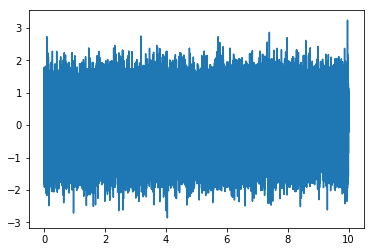

In [56]:
samples = 40000
f=500
s_rate=4000
t=samples/s_rate
nyquist=s_rate/2

x = np.linspace(start=0,num=samples,stop=t)
data = 0.5*np.random.normal(0,1,samples)+1*np.sin(f*t*2*np.pi*x)
plt.plot(x,data)

n = int(2*samples**0.5)
len_fft = n
f_ax, t_ax, stft = scipy.signal.stft(data, nperseg=n, noverlap = n-1, nfft = len_fft)

In [57]:
#%%script false
search_r=10
ridgei=np.zeros(samples)
amplitude=np.zeros(samples,dtype=complex)
stft_abs=np.abs(stft)
ridgei[0]=np.argmax(stft_abs[:,0])

search_r=int(search_r)
for i in range(1,samples):
    if i%10000 == 0:
        print(ridgei[i-1])
    if ridgei[i-1] > search_r+1:
        ridgei[i]=np.argmax(stft_abs[int(ridgei[0])-search_r:int(ridgei[0])+search_r ,i])+ridgei[0]-search_r
    else: 
        ridgei[i]=np.argmax(stft_abs[0:int(ridgei[0])+search_r ,i])
    amplitude[i]=stft[int(ridgei[i]),i]
#print(amplitude)
#print(ridgei)


100.0
100.0
100.0


500.0
400 2000.0


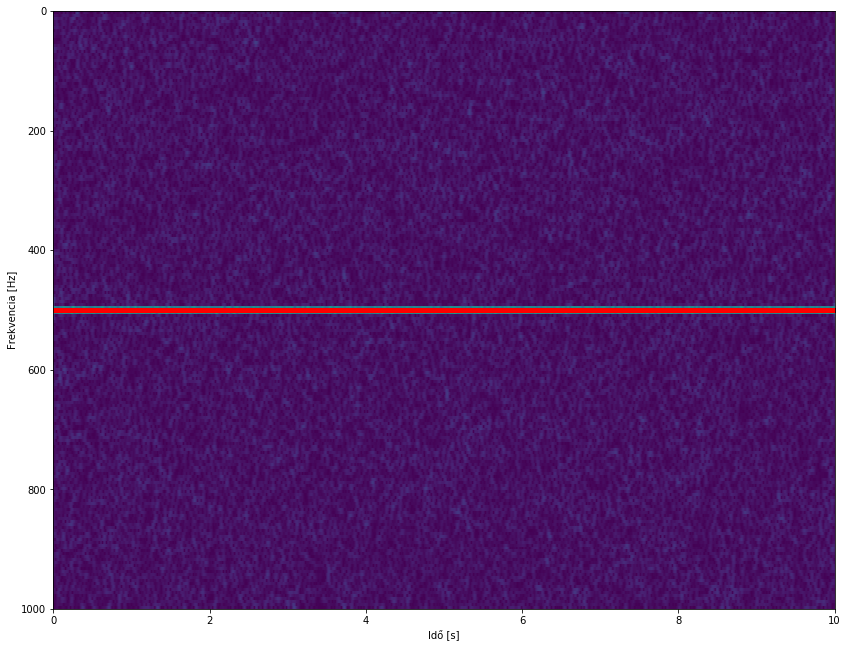

In [58]:
wievd=samples
wievf_i=len_fft
print(np.average(ridgei)/wievf_i*nyquist)
print(len_fft,nyquist)

plt.figure(figsize=(14,11))
plt.imshow(np.abs(stft[:wievf_i,:wievd]),aspect='auto',extent = [0,t,nyquist/2,0])# ,/len_fft*nyquist,0]
plt.plot(x,ridgei[:wievd]/wievf_i*nyquist,'r.-')#/len_fft*nyquist,"r.-"#*wievf*len_fft/s_rate
#plt.ylim(0,600)
#plt.xlim(0,4)
plt.ylabel("Frekvencia [Hz]")
plt.xlabel("Idő [s]")
plt.savefig("test-ridge")
plt.show()

0j


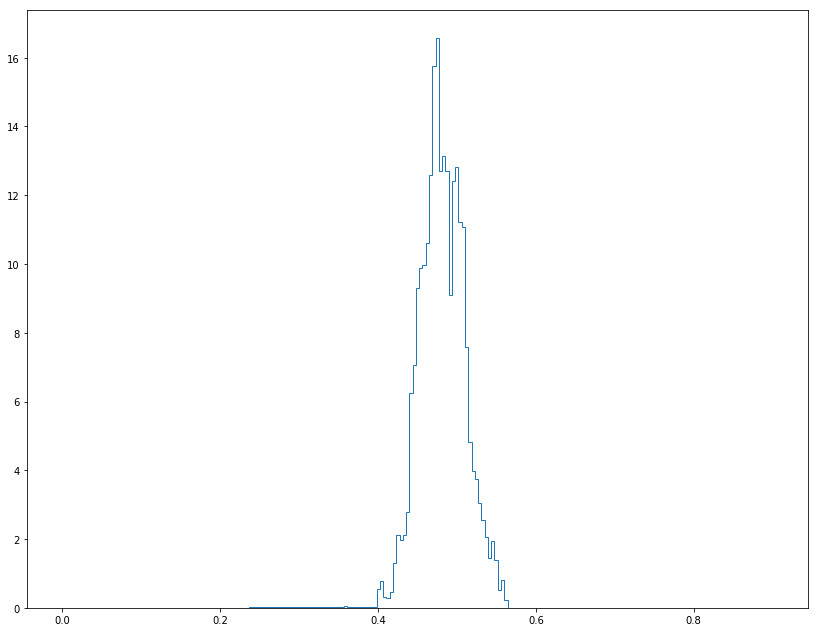

In [50]:
#c = np.abs(chosen).flatten()
#c = chosen.real.flatten()stft[0:15,0:1500]
print(amplitude[0])

#np.seterr(divide='ignore', invalid='ignore')
amplitude=np.abs(stft[int(np.average(ridgei))]).flatten()

plt.figure(figsize=(14,11))
n, bins, patches = plt.hist(np.abs(amplitude), bins=217, density = True,facecolor='b',histtype='step',range=(0.0,0.9))#4.2,4.7
#plt.xlim(4.2,4.7)
plt.savefig("test_hist")
plt.show()
dist_x=bins[:-1]

In [60]:
locg, stdg = scipy.stats.norm.fit(np.abs(amplitude))#,loc=0.5
shape_r,loc_r,scale_r=scipy.stats.rice.fit(np.abs(amplitude))

In [62]:
print(locg,stdg)
print(shape_r,loc_r,scale_r)
print("Amplitúdó Rice eloszlással: ",2*shape_r*scale_r+loc_r)
print("Amplitúdó Gauss eloszlással: ",2*locg, ",  Var: ", np.sqrt(stdg))

0.4996036969190081 0.023893278613531053
21.88184143832104 -0.024038504651849178 0.023905467551893045
Amplitúdó Rice eloszlással:  1.0221527963070554
Amplitúdó Gauss eloszlással:  0.9992073938380162 ,  Var:  0.1545745082914096


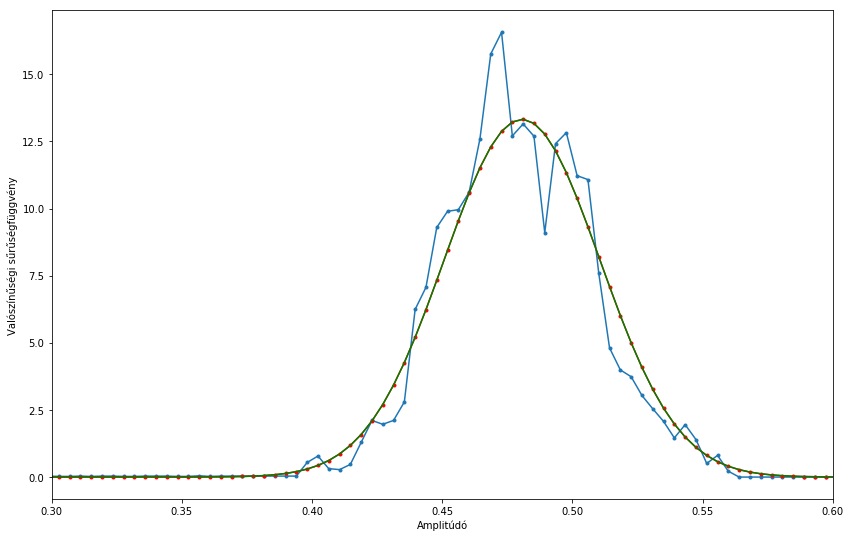

In [53]:
plt.figure(figsize=(14,9))
plt.plot(dist_x,n,'.-')
plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,shape_r,loc_r,scale_r),'r.-') 
plt.plot(dist_x,scipy.stats.norm.pdf(dist_x,loc=locg,scale=stdg),'g-') 
plt.xlim(0.3,0.6)
plt.ylabel("Valószínűségi sűrűségfüggvény")
plt.xlabel("Amplitúdó")
plt.savefig("teszt-rician-fit")
plt.show()

In [ ]:
%%script false
max = np.max(np.abs(stft))
plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, np.abs(stft), vmin=0, vmax=max, shading='plasma')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_abs")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, stft.real, vmin=-max, vmax=max, shading='plasma')
plt.title('STFT Real')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_real")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, stft.imag, vmin=-max, vmax=max, shading='plasma')
plt.title('STFT Imag')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_imag")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, np.angle(stft), vmin=-6, vmax=6, shading='plasma')
plt.title('STFT Phase')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_phase")
plt.show()

In [ ]:
%%script false
shape_h=25
scale_h=25
loc_h=18
diff = np.zeros((shape_h,scale_h,loc_h))
shape = np.linspace(0,8,shape_h)
scale = np.linspace(0.04,0.10,scale_h)
loc = np.linspace(0.0,0.6,loc_h)
for i in range(shape_h):
    for j in range(scale_h):
        for k in range(loc_h):
            diff[i,j,k] = np.average((scipy.stats.rice.pdf(dist_x,shape[i],loc[k],scale[j])-n)**2)
    if i%2 == 0:
        print(i)
#print(divmod(diff.argmin(), diff.shape[1]))

#mini = np.min(diff)
x1,y1,z1=np.unravel_index(diff.argmin(), diff.shape)
print(x1,y1,z1)
print(shape[x1],scale[y1],loc[z1])

plt.figure(figsize=(14,11))
plt.imshow(diff[:,:,z1],aspect='auto')
plt.plot(y1,x1,'ro')
plt.ylabel("shape")
plt.xlabel("scale")
plt.show()